# Intro
My data analysis will predict the direction of the S&P 500 Index

# Import

In [13]:
import datetime
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf

In [14]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period = "max")
sp500.to_csv("/Users/tgut03/Jupyter/Data/sp500 Index.csv")

# Transform

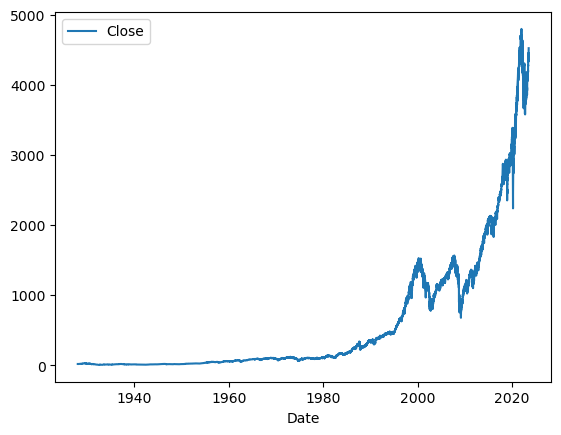

In [15]:
# Convert Data Types
sp500.index = pd.to_datetime(sp500.index, utc = True)
sp500.index = sp500.index.date

# Remove Cols
del sp500["Dividends"]
del sp500["Stock Splits"]

# Plot Close Price
sp500.plot(kind = "line", y = "Close", use_index = True)
plt.xlabel("Date")
plt.show()

In [16]:
# Tomorrow = Close - 1
sp500["Tomorrow"] = sp500["Close"].shift(-1)

# If Up Then 1 Else If Down Then 0
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

# Get Date After Jan 1990
date = datetime.date(1990, 1, 1)
sp500 = sp500[sp500.index >= date].copy()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2023-07-11,4415.549805,4443.640137,4408.459961,4439.259766,3624220000,4472.160156,1
2023-07-12,4467.689941,4488.339844,4463.229980,4472.160156,3920290000,4510.040039,1
2023-07-13,4491.500000,4517.379883,4489.359863,4510.040039,3839530000,4505.419922,0
2023-07-14,4514.609863,4527.759766,4499.560059,4505.419922,3647450000,4521.700195,1


# Model

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

# Split Dataset
train = sp500[:-100]
test = sp500[-100:]

# Select Features
prices = ["Open", "Close", "High", "Low", "Volume"]

# Model
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 1)

# Train Model
model.fit(train[prices], train["Target"])

# Predictions
preds = model.predict(test[prices])
preds = pd.Series(preds, index = test.index)

# 1st Precision
score = precision_score(test["Target"], preds)
print(f"precision = {score.round(2)}")

precision = 0.61


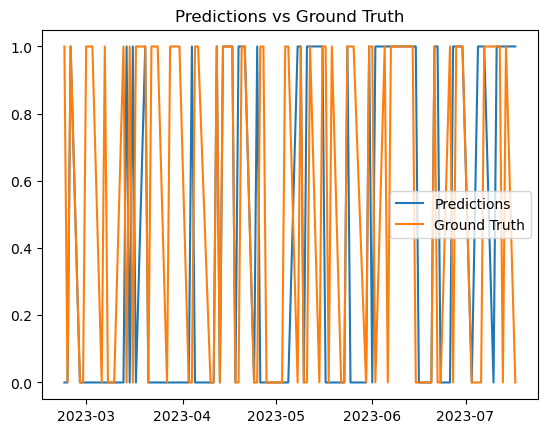

In [18]:
# Concatenation
preds = pd.Series(preds, index = test.index)
predsTruth = pd.concat([preds, test["Target"]], axis = 1)

# Plot Concat
predsTruth.plot(kind = "line")
plt.title("Predictions vs Ground Truth")
plt.legend(["Predictions", "Ground Truth"])
plt.show()

# Automate

In [19]:
# Predict Function
def predict(train, test, prices, model) :
    model.fit(train[prices], train["Target"]) # Train Model
    preds = model.predict(test[prices]) # Predictions
    preds = pd.Series(preds, index = test.index, name = "Predictions") # Predictions
    predsTruth = pd.concat([preds, test["Target"]], axis = 1) # Concatenation
    return predsTruth

# Backtest

In [20]:
# Backtest Function
def backtest(data, prices, model, start = 2500, step = 250) : # 1yr = 250
    totPreds = [] # Total Predictions
    
    for i in range(start, data.shape[0], step) :
        train = data.iloc[0:i].copy() # Window
        test = data.iloc[i:(i+step)].copy() # Sliding Window
        preds2 = predict(train, test, prices, model) # Predict Function
        totPreds.append(preds2) # Append Predictions
    return pd.concat(totPreds)

In [21]:
# Predictions
preds2 = backtest(sp500, prices, model)

# 2nd Precision
score = precision_score(preds2["Target"], preds2["Predictions"])
print(f"precision = {score.round(2)}")

precision = 0.53


# Technicals

In [22]:
# Technical Indicators
horizons = [2, 5, 60, 250, 1000]
teks = []

for horizon in horizons : 
    rollAvgs = sp500.rolling(horizon).mean()
    
    ratio = f"{horizon} Day Close Ratio"
    sp500[ratio] = sp500["Close"] / rollAvgs["Close"]
    
    trend = f"{horizon} Day Trend"
    sp500[trend] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    teks += [ratio, trend]

# Remove Nulls
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,2 Day Close Ratio,2 Day Trend,5 Day Close Ratio,5 Day Trend,60 Day Close Ratio,60 Day Trend,250 Day Close Ratio,250 Day Trend,1000 Day Close Ratio,1000 Day Trend
1993-12-14,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-10,4394.229980,4412.600098,4389.919922,4409.529785,3429600000,4439.259766,1,1.001201,1.0,0.996617,2.0,1.040931,32.0,1.096722,118.0,1.160905,532.0
2023-07-11,4415.549805,4443.640137,4408.459961,4439.259766,3624220000,4472.160156,1,1.003360,2.0,1.004078,2.0,1.046742,32.0,1.103435,119.0,1.168282,533.0
2023-07-12,4467.689941,4488.339844,4463.229980,4472.160156,3920290000,4510.040039,1,1.003692,2.0,1.010361,3.0,1.053115,33.0,1.110872,120.0,1.176480,533.0
2023-07-13,4491.500000,4517.379883,4489.359863,4510.040039,3839530000,4505.419922,0,1.004217,2.0,1.014407,4.0,1.060542,33.0,1.119481,121.0,1.185976,533.0


# Probability

In [23]:
# Model
model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1)

# Predict Probability Function
def predictProba(train, test, prices, model) :
    model.fit(train[prices], train["Target"]) # Train Model
    preds = model.predict_proba(test[prices])[:,1] # Predictions Probability
    preds[preds >= 0.6] = 1 # Up Probability Level
    preds[preds < 0.6] = 0 # Down Probability Level
    preds = pd.Series(preds, index = test.index, name = "Predictions") # Predictions
    predsTruth = pd.concat([preds, test["Target"]], axis = 1) # Concatenation
    return predsTruth

In [24]:
# Predictions
preds2 = backtest(sp500, teks, model)
preds2["Predictions"].value_counts()

# 3rd Precision
score = precision_score(preds2["Target"], preds2["Predictions"])
print(f"precision = {score.round(2)}")

# Ground Truth
truth = (preds2["Target"].value_counts() / preds2["Predictions"].shape[0]).round(2)
positiveTruth = truth[1]
print(f"ground truth 1s = {positiveTruth}")

precision = 0.55
ground truth 1s = 0.54


# Conclusion
To conclude, my model correctly predicted the S&P 500 Index would go up 55% of the days while the S&P 500 Index went up 54% of the days.